## The forward and backward passes

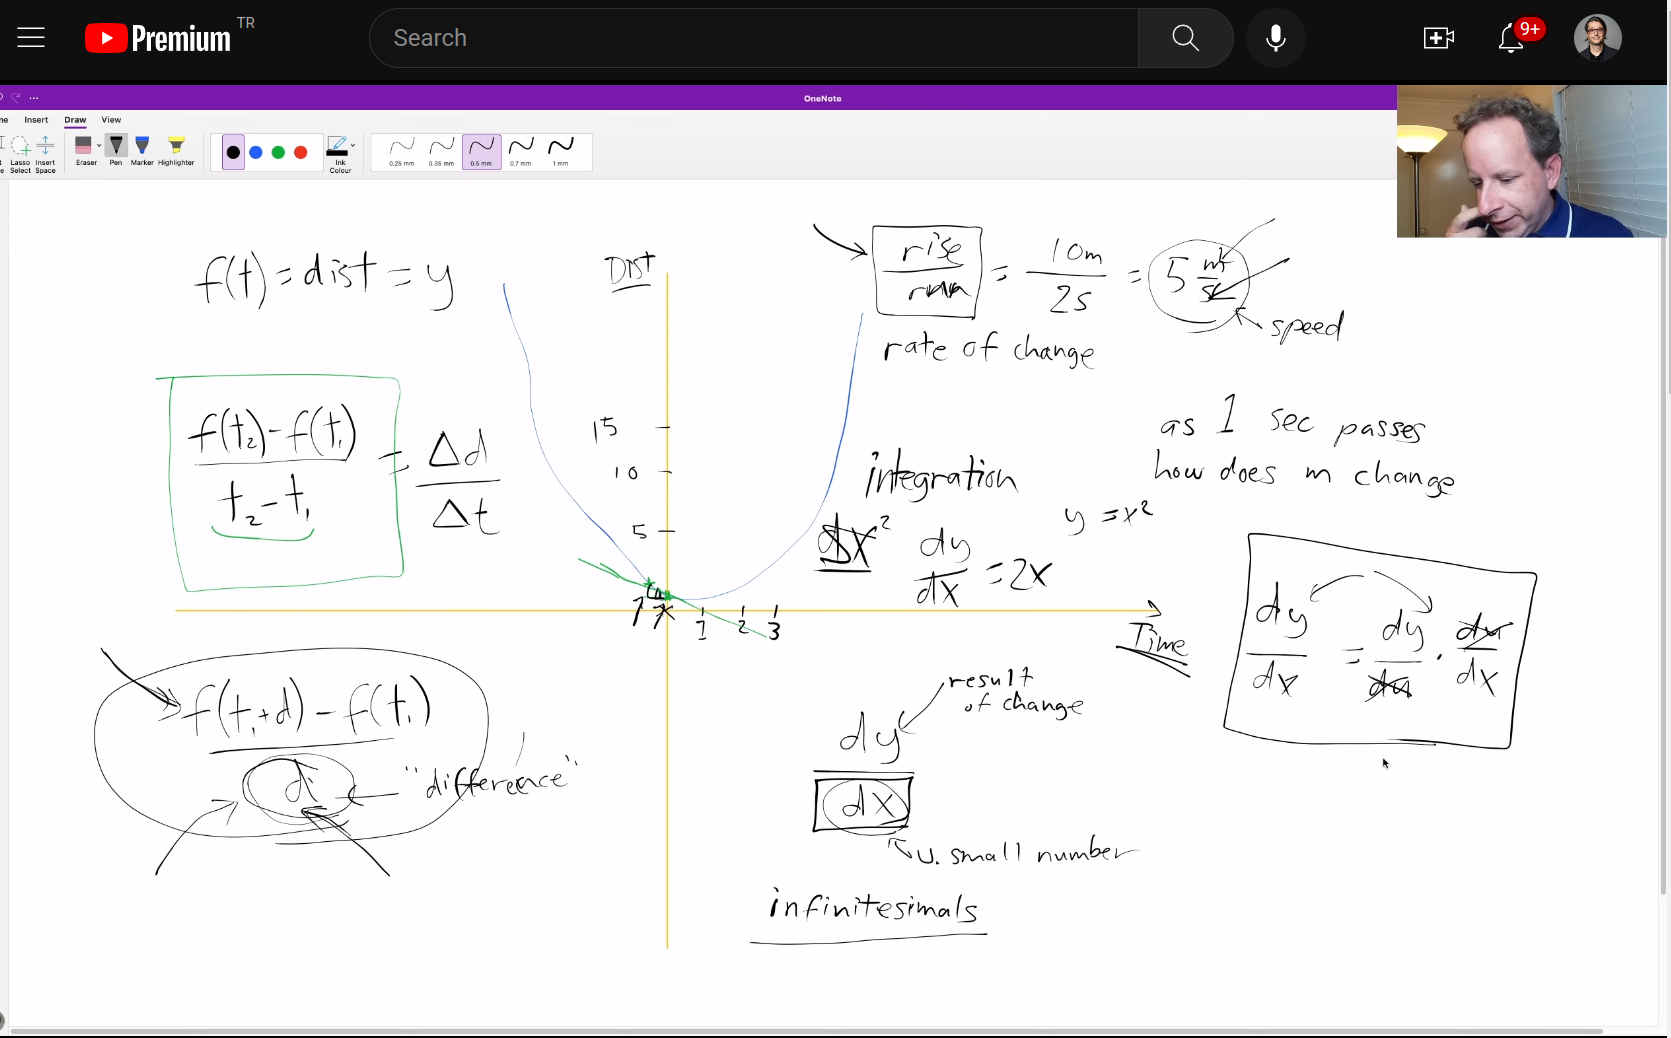

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
from torch import tensor
from fastcore.test import test_close
torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Foundations version

### Basic architecture

In [ ]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

In [ ]:
# num hidden
nh = 50

In [ ]:
w1 = torch.randn(m,nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)
b2 = torch.zeros(1)

In [ ]:
def lin(x, w, b): return x@w + b

In [ ]:
t = lin(x_valid, w1, b1)
t.shape

torch.Size([10000, 50])

In [ ]:
def relu(x): return x.clamp_min(0.)

In [ ]:
t = relu(t)
t

tensor([[ 0.00, 11.87,  0.00,  ...,  5.48,  2.14, 15.30],
        [ 5.38, 10.21,  0.00,  ...,  0.88,  0.08, 20.23],
        [ 3.31,  0.12,  3.10,  ..., 16.89,  0.00, 24.74],
        ...,
        [ 4.01, 10.35,  0.00,  ...,  0.23,  0.00, 18.28],
        [10.62,  0.00, 10.72,  ...,  0.00,  0.00, 18.23],
        [ 2.84,  0.00,  1.43,  ...,  0.00,  5.75,  2.12]])

In [ ]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    return lin(l2, w2, b2)

In [ ]:
res = model(x_valid)
res.shape

torch.Size([10000, 1])

### Loss function: MSE

(Of course, `mse` is not a suitable loss function for multi-class classification; we'll use a better loss function soon. We'll use `mse` for now to keep things simple.)

In [ ]:
res.shape,y_valid.shape

(torch.Size([10000, 1]), torch.Size([10000]))

In [ ]:
(res-y_valid).shape

torch.Size([10000, 10000])

We need to get rid of that trailing (,1), in order to use `mse`.

In [ ]:
res[:,0].shape

torch.Size([10000])

In [ ]:
res.squeeze().shape

torch.Size([10000])

In [ ]:
(res[:,0]-y_valid).shape

torch.Size([10000])

In [ ]:
y_train,y_valid = y_train.float(),y_valid.float()

preds = model(x_train)
preds.shape

torch.Size([50000, 1])

In [ ]:
def mse(output, targ): return (output[:,0]-targ).pow(2).mean()

In [ ]:
mse(preds, y_train)

tensor(4308.76)

### Gradients and backward pass

In [ ]:
from sympy import symbols,diff
x,y = symbols('x y')
diff(x**2, x)

2*x

In [ ]:
diff(3*x**2+9, x)

6*x

:::{.callout-note}

## Steps of the back-propagation


:::


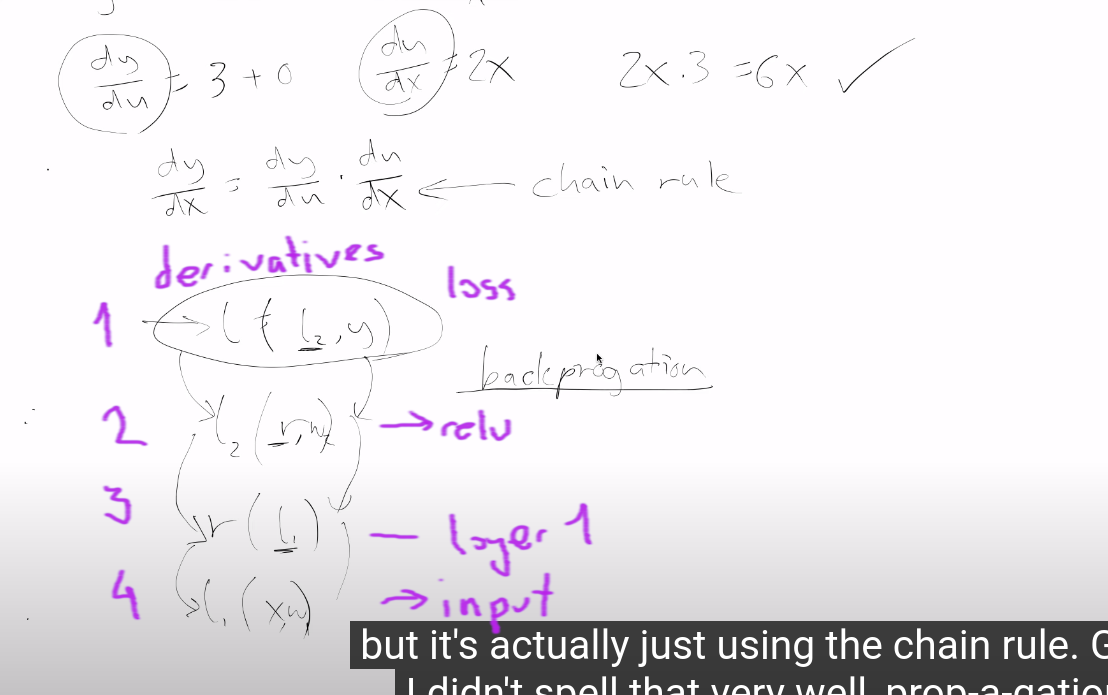

:::{.callout-note}

## Further reading

- check here too for a more detailed explanation of backpropagation. Same thing but includes extra-steps. [https://course19.fast.ai/videos/?lesson=8m](https://course19.fast.ai/videos/?lesson=8m) around 1:53
code here too [https://github.com/fastai/course-v3/blob/master/nbs/dl2/02_fully_connected.ipynb](https://github.com/fastai/course-v3/blob/master/nbs/dl2/02_fully_connected.ipynb)
    - Gradient of the relu.
    - mse grad( gradient of the loss)
    - gradient of the linear layer.    
- The Intuitive Notion of the Chain Rule
    - [https://webspace.ship.edu/msrenault/geogebracalculus/derivative_intuitive_chain_rule.html](https://webspace.ship.edu/msrenault/geogebracalculus/derivative_intuitive_chain_rule.html)
- The Matrix Calculus You Need For Deep Learning
    - [https://explained.ai/matrix-calculus/](https://explained.ai/matrix-calculus/)

:::



In [ ]:
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    #import pdb; pdb.set_trace()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [ ]:
def forward_and_backward(inp, targ):
    # forward pass:
    l1 = lin(inp, w1, b1)
    l2 = relu(l1)
    out = lin(l2, w2, b2)
    diff = out[:,0]-targ
    loss = diff.pow(2).mean()
    
    # backward pass:
    out.g = 2.*diff[:,None] / inp.shape[0]
    lin_grad(l2, out, w2, b2)
    l1.g = (l1>0).float() * l2.g
    lin_grad(inp, l1, w1, b1)

In [ ]:
forward_and_backward(x_train, y_train)

In [ ]:
# Save for testing against later
def get_grad(x): return x.g.clone()
chks = w1,w2,b1,b2,x_train
grads = w1g,w2g,b1g,b2g,ig = tuple(map(get_grad, chks))

We cheat a little bit and use PyTorch autograd to check our results.

In [ ]:
def mkgrad(x): return x.clone().requires_grad_(True)
ptgrads = w12,w22,b12,b22,xt2 = tuple(map(mkgrad, chks))

In [ ]:
def forward(inp, targ):
    l1 = lin(inp, w12, b12)
    l2 = relu(l1)
    out = lin(l2, w22, b22)
    return mse(out, targ)

In [ ]:
loss = forward(xt2, y_train)
loss.backward()

In [ ]:
for a,b in zip(grads, ptgrads): test_close(a, b.grad, eps=0.01)

## Refactor model

### Layers as classes

In [ ]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)
        return self.out
    
    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

In [ ]:
class Lin():
    def __init__(self, w, b): self.w,self.b = w,b

    def __call__(self, inp):
        self.inp = inp
        self.out = lin(inp, self.w, self.b)
        return self.out

    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        #self.w.g = self.inp.t() @ self.out.g
        #self.b.g = self.out.g.sum(0)

In [ ]:
class Mse():
    def __call__(self, inp, targ):
        self.inp,self.targ = inp,targ
        self.out = mse(inp, targ)
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [ ]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [ ]:
model = Model(w1, b1, w2, b2)

In [ ]:
loss = model(x_train, y_train)

In [ ]:
model.backward()

In [ ]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

### Module.forward()

In [ ]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out

    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)
    def bwd(self): raise Exception('not implemented')

In [ ]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [ ]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
    def forward(self, inp): return inp@self.w + self.b
    def bwd(self, out, inp):
        inp.g = self.out.g @ self.w.t()
        self.w.g = inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [ ]:
class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [ ]:
model = Model(w1, b1, w2, b2)

In [ ]:
loss = model(x_train, y_train)

In [ ]:
model.backward()

In [ ]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

### Autograd

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
class Linear(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = torch.randn(n_in,n_out).requires_grad_()
        self.b = torch.zeros(n_out).requires_grad_()
    def forward(self, inp): return inp@self.w + self.b

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [Linear(n_in,nh), nn.ReLU(), Linear(nh,n_out)]
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return F.mse_loss(x, targ[:,None])

In [ ]:
model = Model(m, nh, 1)
loss = model(x_train, y_train)
loss.backward()

In [ ]:
l0 = model.layers[0]
l0.b.grad

tensor([-19.60,  -2.40,  -0.12,   1.99,  12.78, -15.32, -18.45,   0.35,   3.75,  14.67,  10.81,  12.20,  -2.95, -28.33,
          0.76,  69.15, -21.86,  49.78,  -7.08,   1.45,  25.20,  11.27, -18.15, -13.13, -17.69, -10.42,  -0.13, -18.89,
        -34.81,  -0.84,  40.89,   4.45,  62.35,  31.70,  55.15,  45.13,   3.25,  12.75,  12.45,  -1.41,   4.55,  -6.02,
        -62.51,  -1.89,  -1.41,   7.00,   0.49,  18.72,  -4.84,  -6.52])